In [1]:
import os
os.chdir('/grid_mnt/data_cms_upgrade/biriukov/TICL_Validation/python')
from validation.DataFile import *
from validation.DataProcessor import *
from validation.NTupler import *
from validation.Plotter import *
from typing import List, Union

# for plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import mplhep as hep
plt.style.use(hep.style.CMS)
#filepath = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'
filepath = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_10_1000/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'

tfile = DataFile(filepath)
tprocessor = DataProcessor()

# Efficiency

**Efficiency** is a fraction of simulated objects well matched to at least one reconstructed. Association simToReco_score is used to quantify how well simulated and reconstructed objetcts are matched. In order to compute efficiency one has to define a threshold which represents an upper boundary for simToReco_score showing "good mathichg". *Therefore*, chosing threshold to be equal to $\alpha$ ($ 0 < \alpha < 1$ ) leads to the following definition of efficiency:
$
\begin{equation}
    \text{eff}^{\alpha}_{bin} = \frac{\sum_{i \in \{ \text{all CP within a bin}\}} \delta (\alpha - \text{simToReco\_score}_i)}{\sum_{i \in \{ \text{all CP within a bin}\}}}
\end{equation}
$

In [19]:
def getBinningArray(binning_key: str, opt_map: List[bool]=None):
    if 'eta' in binning_key:
        binning_array = np.abs(tfile.openArray(branch_name="ticlDumper/simtrackstersCP;1", key=binning_key))
    else:
        binning_array = tfile.openArray(branch_name="ticlDumper/simtrackstersCP;1", key=binning_key)

    if opt_map is not None:
        binning_array = binning_array[opt_map]

    return binning_array

# Get bin edges for variable to plot efficiency against.
def getEdges(binning_array: List[float],  n_bins: int, binning_opt: str=None):

    min_val = np.min(binning_array)
    max_val = np.max(binning_array)
    if binning_opt == 'log':
        return np.logspace(np.log10(min_val), np.log10(max_val), n_bins + 1)
    else:
        return np.linspace(min_val, max_val, n_bins)

def getEfficiency(binning_array: List[float], edges: List[float], threshold: float):
    simToReco_score = tfile.openArray(branch_name="ticlDumper/associations", key="tsCLUE3D_simToReco_CP_score")

    n_bins = len(edges) - 1
    efficiency = []
    n_events = []
    for bin in range(n_bins):
        bin_map = (binning_array >= edges[bin]) & (binning_array < edges[bin + 1])
        scores_per_bin = ak.flatten(simToReco_score[bin_map])[:, 0]
        pass_threshold = len(scores_per_bin[scores_per_bin < threshold])
        efficiency.append(pass_threshold/len(scores_per_bin))
        n_events.append(len(scores_per_bin))

    return [efficiency, n_events]

def getCI(efficiency: List[float], n_events: List[int], ci_opt: str):
    from statsmodels.stats.proportion import proportion_confint

    ci_low, ci_high = proportion_confint(np.array(efficiency)*np.array(n_events), n_events, method=ci_opt)

    ci = []
    ci.append(ci_low/np.sqrt(np.array(n_events)))
    ci.append(ci_high/np.sqrt(np.array(n_events)))

    return ci

def makePlot(data: List[Union[float, int]],
             bins: List[float],
             errorbars: List[List[float]],
             mode: str,
             threshold: float, 
             plotLabel: str = None):
    # mode represents name of binning variables
    # available options: energy, eta, hd, ld
    if mode == 'energy' or mode == 'hd' or mode == 'ld':
        xlabel = 'E (GeV)'
    if mode == 'eta':
        xlabel = r'$\eta$'
    if mode == 'hd':
        plotLabel = 'HD'
    if mode == 'ld':
        plotLabel = 'LD'
    fig, ax = plt.subplots()
    
    bin_centers = (bins[1:] + bins[:-1])/2
    bin_widths = (bins[1:] - bins[:-1])/2
    if plotLabel is None:
        ax.errorbar(bin_centers, data, yerr=errorbars, xerr=bin_widths, marker='s', ms=3)
    else:
        ax.errorbar(bin_centers, data, yerr=errorbars, xerr=bin_widths, marker='s', ms=3, label=plotLabel)
        ax.legend()
    ax.axhline(y=1, linestyle = '--', linewidth=2)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(np.min(bins), np.max(bins))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(f'Efficiency (threshold = {threshold})')
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=0", ax=ax)
    
    hist_name = xlabel.replace(' (GeV)', '')
    if plotLabel is not None:
        hist_name += f'_{plotLabel}'
    hist_name += f'_th_{threshold}'
    path_to_save = f'plots/efficiency'
    os.makedirs(path_to_save, exist_ok=True)
    plt.savefig(f'{path_to_save}/{hist_name}.png')
    
def makePlotSequence(container, binning_opt: str):
    # container is a List of required data for each of plots within a sequence.
    # By sequence I mean plots with different threshold value (everything else must be
    # the same for proper comparison)
    #
    # container has the following structure
    # [sequence_1, sequence_2, sequence_3 ...]
    # sequence_i = [data_i, bins, errorbars_i, mode, threshold_i]
    #
    # Be carefull! mode and bins are the same for all sequences
    mode = container[0][3]
    plotLabel = None

    if mode == 'energy' or mode == 'hd' or mode == 'ld' or mode == 'hd-ld':
        xlabel = 'E (GeV)'
    if mode == 'eta':
        xlabel = r'$\eta$'
    if mode == 'hd':
        plotLabel = 'HD'
    if mode == 'ld':
        plotLabel = 'LD'
    if mode == 'hd-ld':
        plotLabel = 'HD-LD barrier'
    if plotLabel is not None:
        xlabel = f'{xlabel} {plotLabel}'
    fig, ax = plt.subplots()

    bins = container[0][1]
    bin_centers = (bins[1:] + bins[:-1])/2
    bin_widths = (bins[1:] - bins[:-1])/2
    thresholds = []     # for hist_name
    for sequence in container:
        ax.errorbar(bin_centers, sequence[0], yerr=sequence[2], xerr=bin_widths, marker='s', ms=3, label=f'threshold = {sequence[4]}')
        thresholds.append(sequence[4])
    
    ax.axhline(y=1, linestyle = '--', linewidth=2)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(np.min(bins), np.max(bins))
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Efficiency')
    if binning_opt == 'log':
        ax.set_xscale('log')
    ax.legend()
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=0", ax=ax)
    
    hist_name = xlabel.replace(' (GeV)', ''). replace('HD', '').replace('LD', '').replace('$', '').replace('\\', '').replace(' ', '').replace('barrier', '')
    if plotLabel is not None:
        hist_name += f'_{plotLabel}'
    hist_name += f'_th'
    for th in thresholds:
        th = str(th).split('.')[-1]
        hist_name += f'_{th}'
    path_to_save = f'plots/efficiency'
    os.makedirs(path_to_save, exist_ok=True)
    plt.savefig(f'{path_to_save}/{hist_name}.png')

def producePlot(filepath: str,
                binning_key: str,
                opt_map: List[bool] = None,
                n_bins: int = None,
                binning_opt: str = None,
                threshold: Union[float, List[float]] = None,
                mode: str = None,
                ci_opt: str = None):
    
    if os.path.exists(filepath):
        tfile = DataFile(filepath)
    else:
        raise Exception("These is no such file")
    
    binning_array = getBinningArray(binning_key, opt_map)
    edges = getEdges(binning_array, n_bins, binning_opt)
    efficiency = getEfficiency(binning_array, edges, threshold)
    errorbars = getCI(efficiency[0], efficiency[1], ci_opt)
    makePlot(efficiency[0], edges, errorbars, mode, threshold)

def producePlotSequence(filepath: str,
                        binning_key: str,
                        opt_map: List[bool] = None,
                        n_bins: int = None,
                        binning_opt: str = None,
                        threshold: List[float] = None,
                        mode: str = None,
                        ci_opt: str = None):
    
    if os.path.exists(filepath):
        tfile = DataFile(filepath)
    else:
        raise Exception("These is no such file")
    
    binning_array = getBinningArray(binning_key, opt_map)
    edges = getEdges(binning_array, n_bins, binning_opt)
    container = []
    for th in threshold:
        efficiency = getEfficiency(binning_array, edges, th)
        errorbars = getCI(efficiency[0], efficiency[1], ci_opt)
        container.append([efficiency[0], edges, errorbars, mode, th])

    makePlotSequence(container, binning_opt)

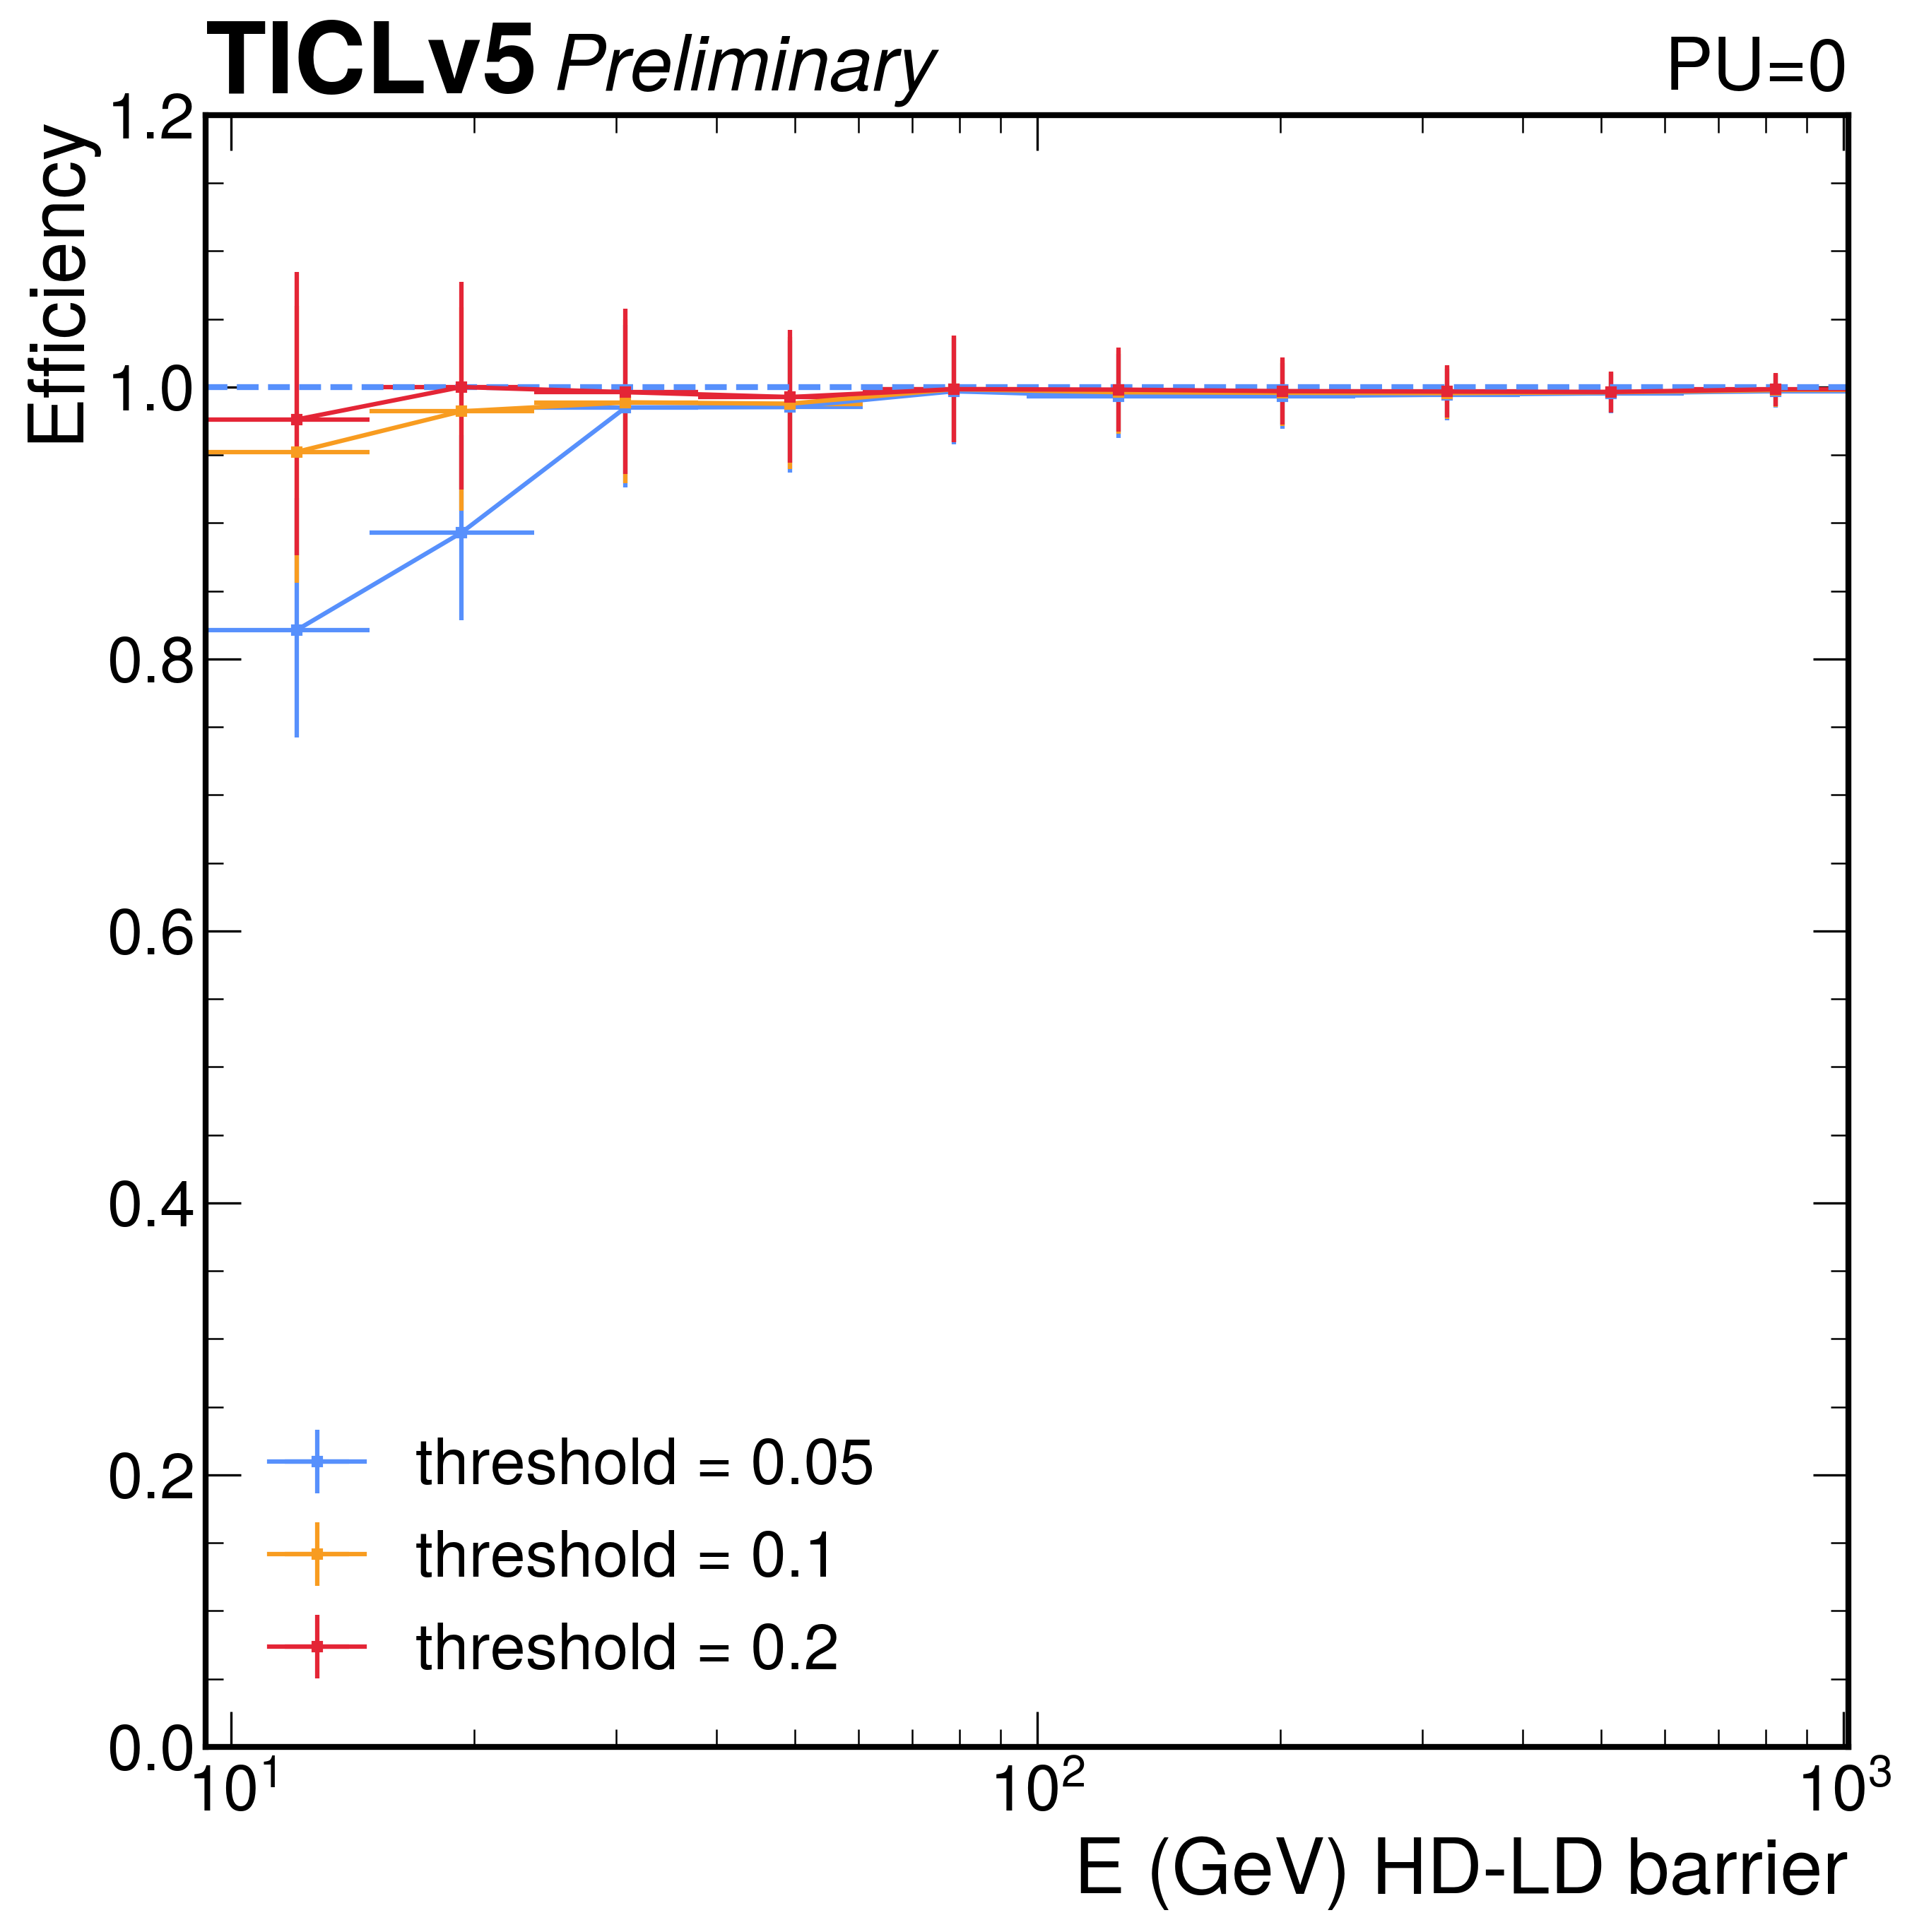

In [22]:
producePlotSequence(filepath,
                    binning_key='raw_energy',
                    opt_map=hd_ld_map,
                    n_bins=10,
                    binning_opt='log',
                    threshold=[0.05, 0.1, 0.2],
                    mode='hd-ld',
                    ci_opt='wilson')

In [21]:
# Definitions of maps
raw_energy = tfile.openArray(branch_name="ticlDumper/simtrackstersCP;1", key="raw_energy")
barycenter_eta = np.abs(tfile.openArray(branch_name="ticlDumper/simtrackstersCP;1", key="barycenter_eta"))
hd_map = barycenter_eta < 2.02      # only HD region
ld_map = barycenter_eta > 2.02      # only LD region
hd_ld_map = (barycenter_eta > 1.9) & (barycenter_eta < 2.1)

e_50 = raw_energy < 50
e_30 = raw_energy < 30
e_200 = raw_energy < 200

In [15]:
# Example of use of functions

binning_key = "raw_energy"
n_bins = 10
threshold = 0.2
opt_map = hd_map & e_200
ci_opt = 'wilson'

binning_array = getBinningArray(binning_key)
edges = getEdges(binning_array, n_bins)
efficiency = getEfficiency(binning_array, edges, threshold)
errorbars = getCI(efficiency[0],efficiency[1], ci_opt)

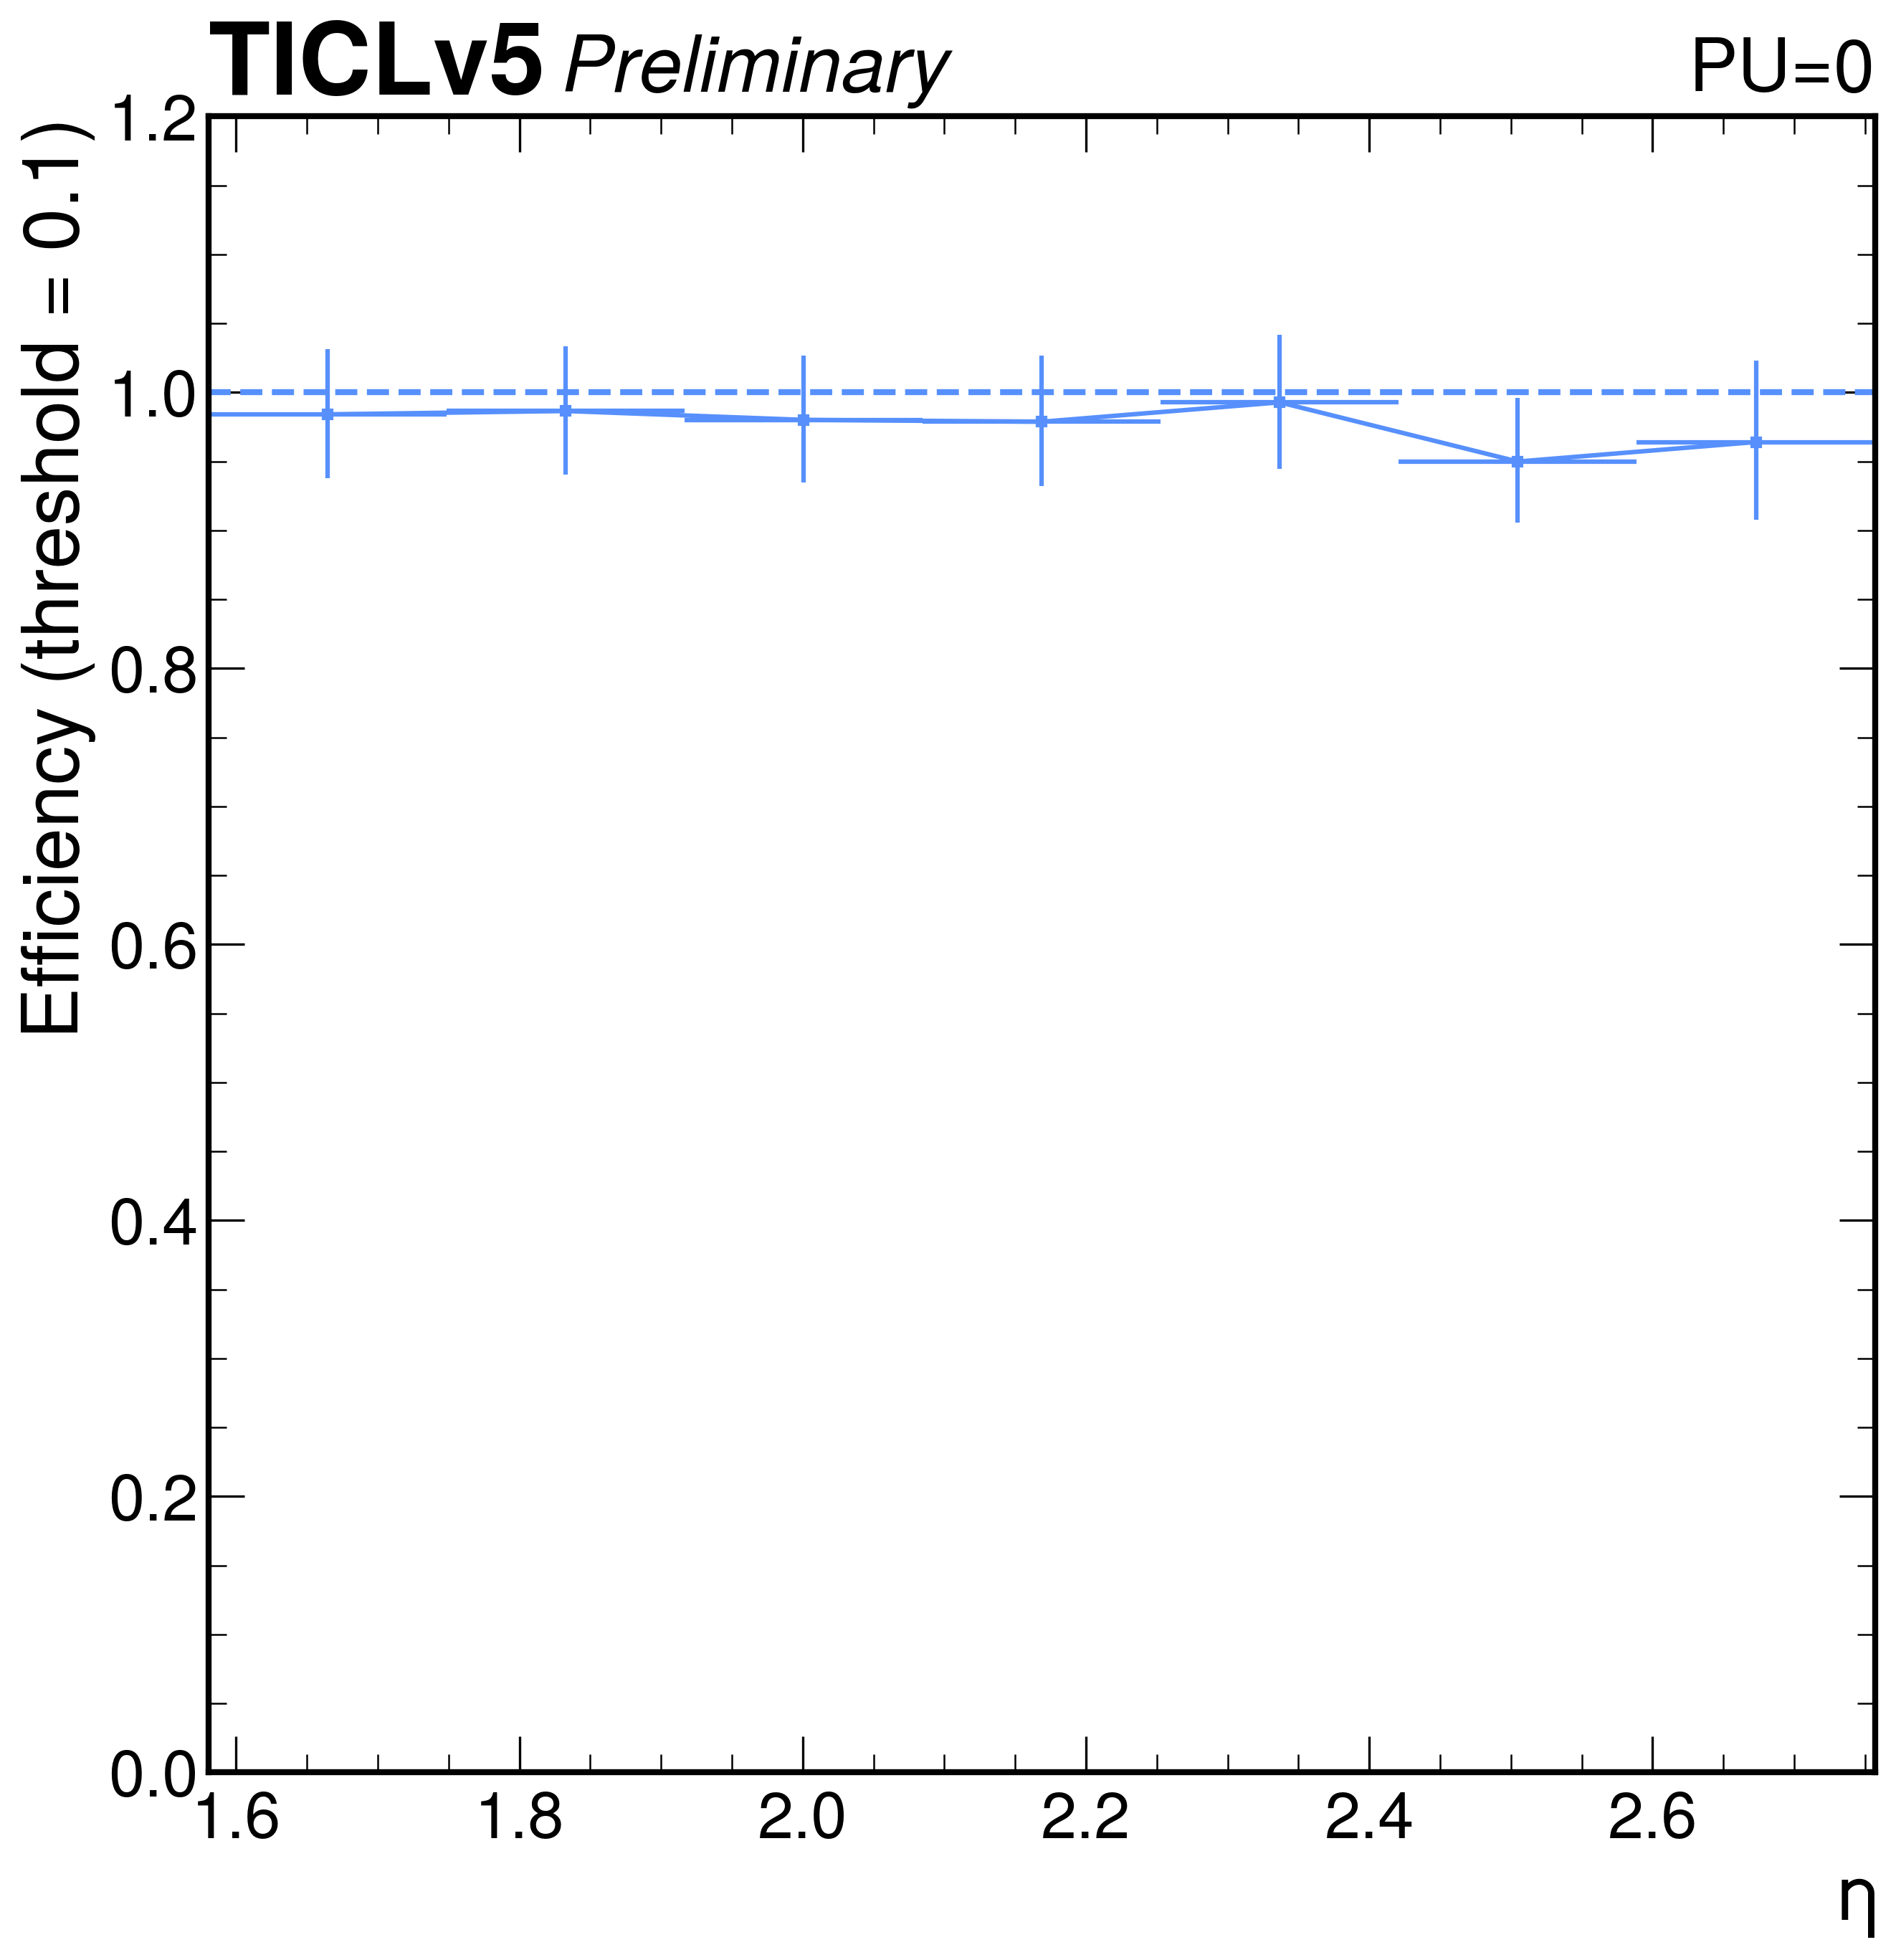

In [38]:
binning_key = "barycenter_eta"
n_bins = 8
threshold = 0.1
opt_map = (raw_energy > 15.)
ci_opt = 'wilson'
mode = 'eta'

binning_array = getBinningArray(binning_key, opt_map)
edges = getEdges(binning_array, n_bins)
efficiency = getEfficiency(binning_array, edges, threshold)
errorbars = getCI(efficiency[0],efficiency[1], ci_opt)
makePlot(efficiency[0], edges, errorbars, mode, threshold)

In [6]:
# define edges from input data
optional_map = ld_map
binning_array = np.abs(tfile.openArray(branch_name="ticlDumper/simtrackstersCP;1", key=binning_key))
binning_array = binning_array[optional_map & e_200]
max_bin_val = np.max(binning_array)
min_bin_val = np.min(binning_array)
edges = np.array([np.min(binning_array) + k*(np.max(binning_array) - np.min(binning_array))/n_bins for k in range(0, n_bins + 1)])

In [14]:
getEdges(binning_key, n_bins, binning_opt='log', opt_map=(ld_map & e_200))

array([  7.060981,   9.864598,  13.781415,  19.253435,  26.898159,
        37.578285,  52.499046,  73.34419 , 102.466064, 143.15108 ,
       199.9903  ], dtype=float32)

In [12]:
edges

array([  7.060981,  26.353909,  45.646835,  64.939766,  84.23269 ,
       103.52562 , 122.81855 , 142.11147 , 161.40439 , 180.69733 ,
       199.99025 ], dtype=float32)

In [4]:
simToReco_score = tfile.openArray(branch_name="ticlDumper/associations", key="tsCLUE3D_simToReco_CP_score")

In [23]:
# computation of effeciency in each bin of binning_array

efficiency = []
n_events = []

for bin in range(n_bins):
    bin_map = (binning_array >= edges[bin]) & (binning_array < edges[bin + 1])
    scores_per_bin = ak.flatten(simToReco_score[bin_map])[:, 0]
    pass_threshold = len(scores_per_bin[scores_per_bin < threshold])
    if len(scores_per_bin) > 0:
        efficiency.append(pass_threshold/len(scores_per_bin))
        n_events.append(len(scores_per_bin))
    else:
        print('0 events!')
        efficiency.append(1.)


In [24]:
# compute error (using bootstrapping)

def create_boolean_array(N, M):
    if M > N:
        raise ValueError("M cannot be greater than N")
    
    arr = np.zeros(N, dtype=bool)  # Step 1: Create an array of all False
    indices = np.random.choice(N, M, replace=False)  # Step 2: Select M unique indices
    arr[indices] = True  # Step 3: Set selected indices to True
    
    return arr

bs_error = []
for bin in range(n_bins):
    bs_eff = []
    for i in range(5000):
        filter_arr = create_boolean_array(50000, 40000)
        binning_array_bs = binning_array[filter_arr]
        scores_per_bin = simToReco_score[filter_arr]
        bin_map = (binning_array_bs >= edges[bin]) & (binning_array_bs < edges[bin + 1])
        scores_per_bin = ak.flatten(scores_per_bin[bin_map])[:, 0]
        pass_threshold = len(scores_per_bin[scores_per_bin < threshold])
        bs_eff.append(pass_threshold/len(scores_per_bin))

    bs_eff = np.array(bs_eff)
    bs_mean = np.mean(bs_eff)
    bs_stdev = np.sqrt(np.dot((bs_eff - bs_mean),(bs_eff - bs_mean))/(len(bs_eff) - 1))
    bs_error.append(bs_stdev)

In [25]:
#effiniency_hd = [efficiency, bs_error]
effiniency_ld = [efficiency, bs_error]

In [43]:
# compute errors (using Wilson interval)

error = []

for bin in range(n_bins):
    z = 0.5
    p = efficiency[bin]
    n = n_events[bin]
    med = p + z**2/(2*n)
    desc = np.sqrt(p*(1 - p)/n + z**2/(4*n**2))
    denom = 1 + z**2/n

    w_low = (med - desc)/denom
    w_high = (med + desc)/denom

    error.append([w_low, w_high])

In [44]:
error = list(map(list, zip(*error)))

Text(0, 1, 'Efficiency')

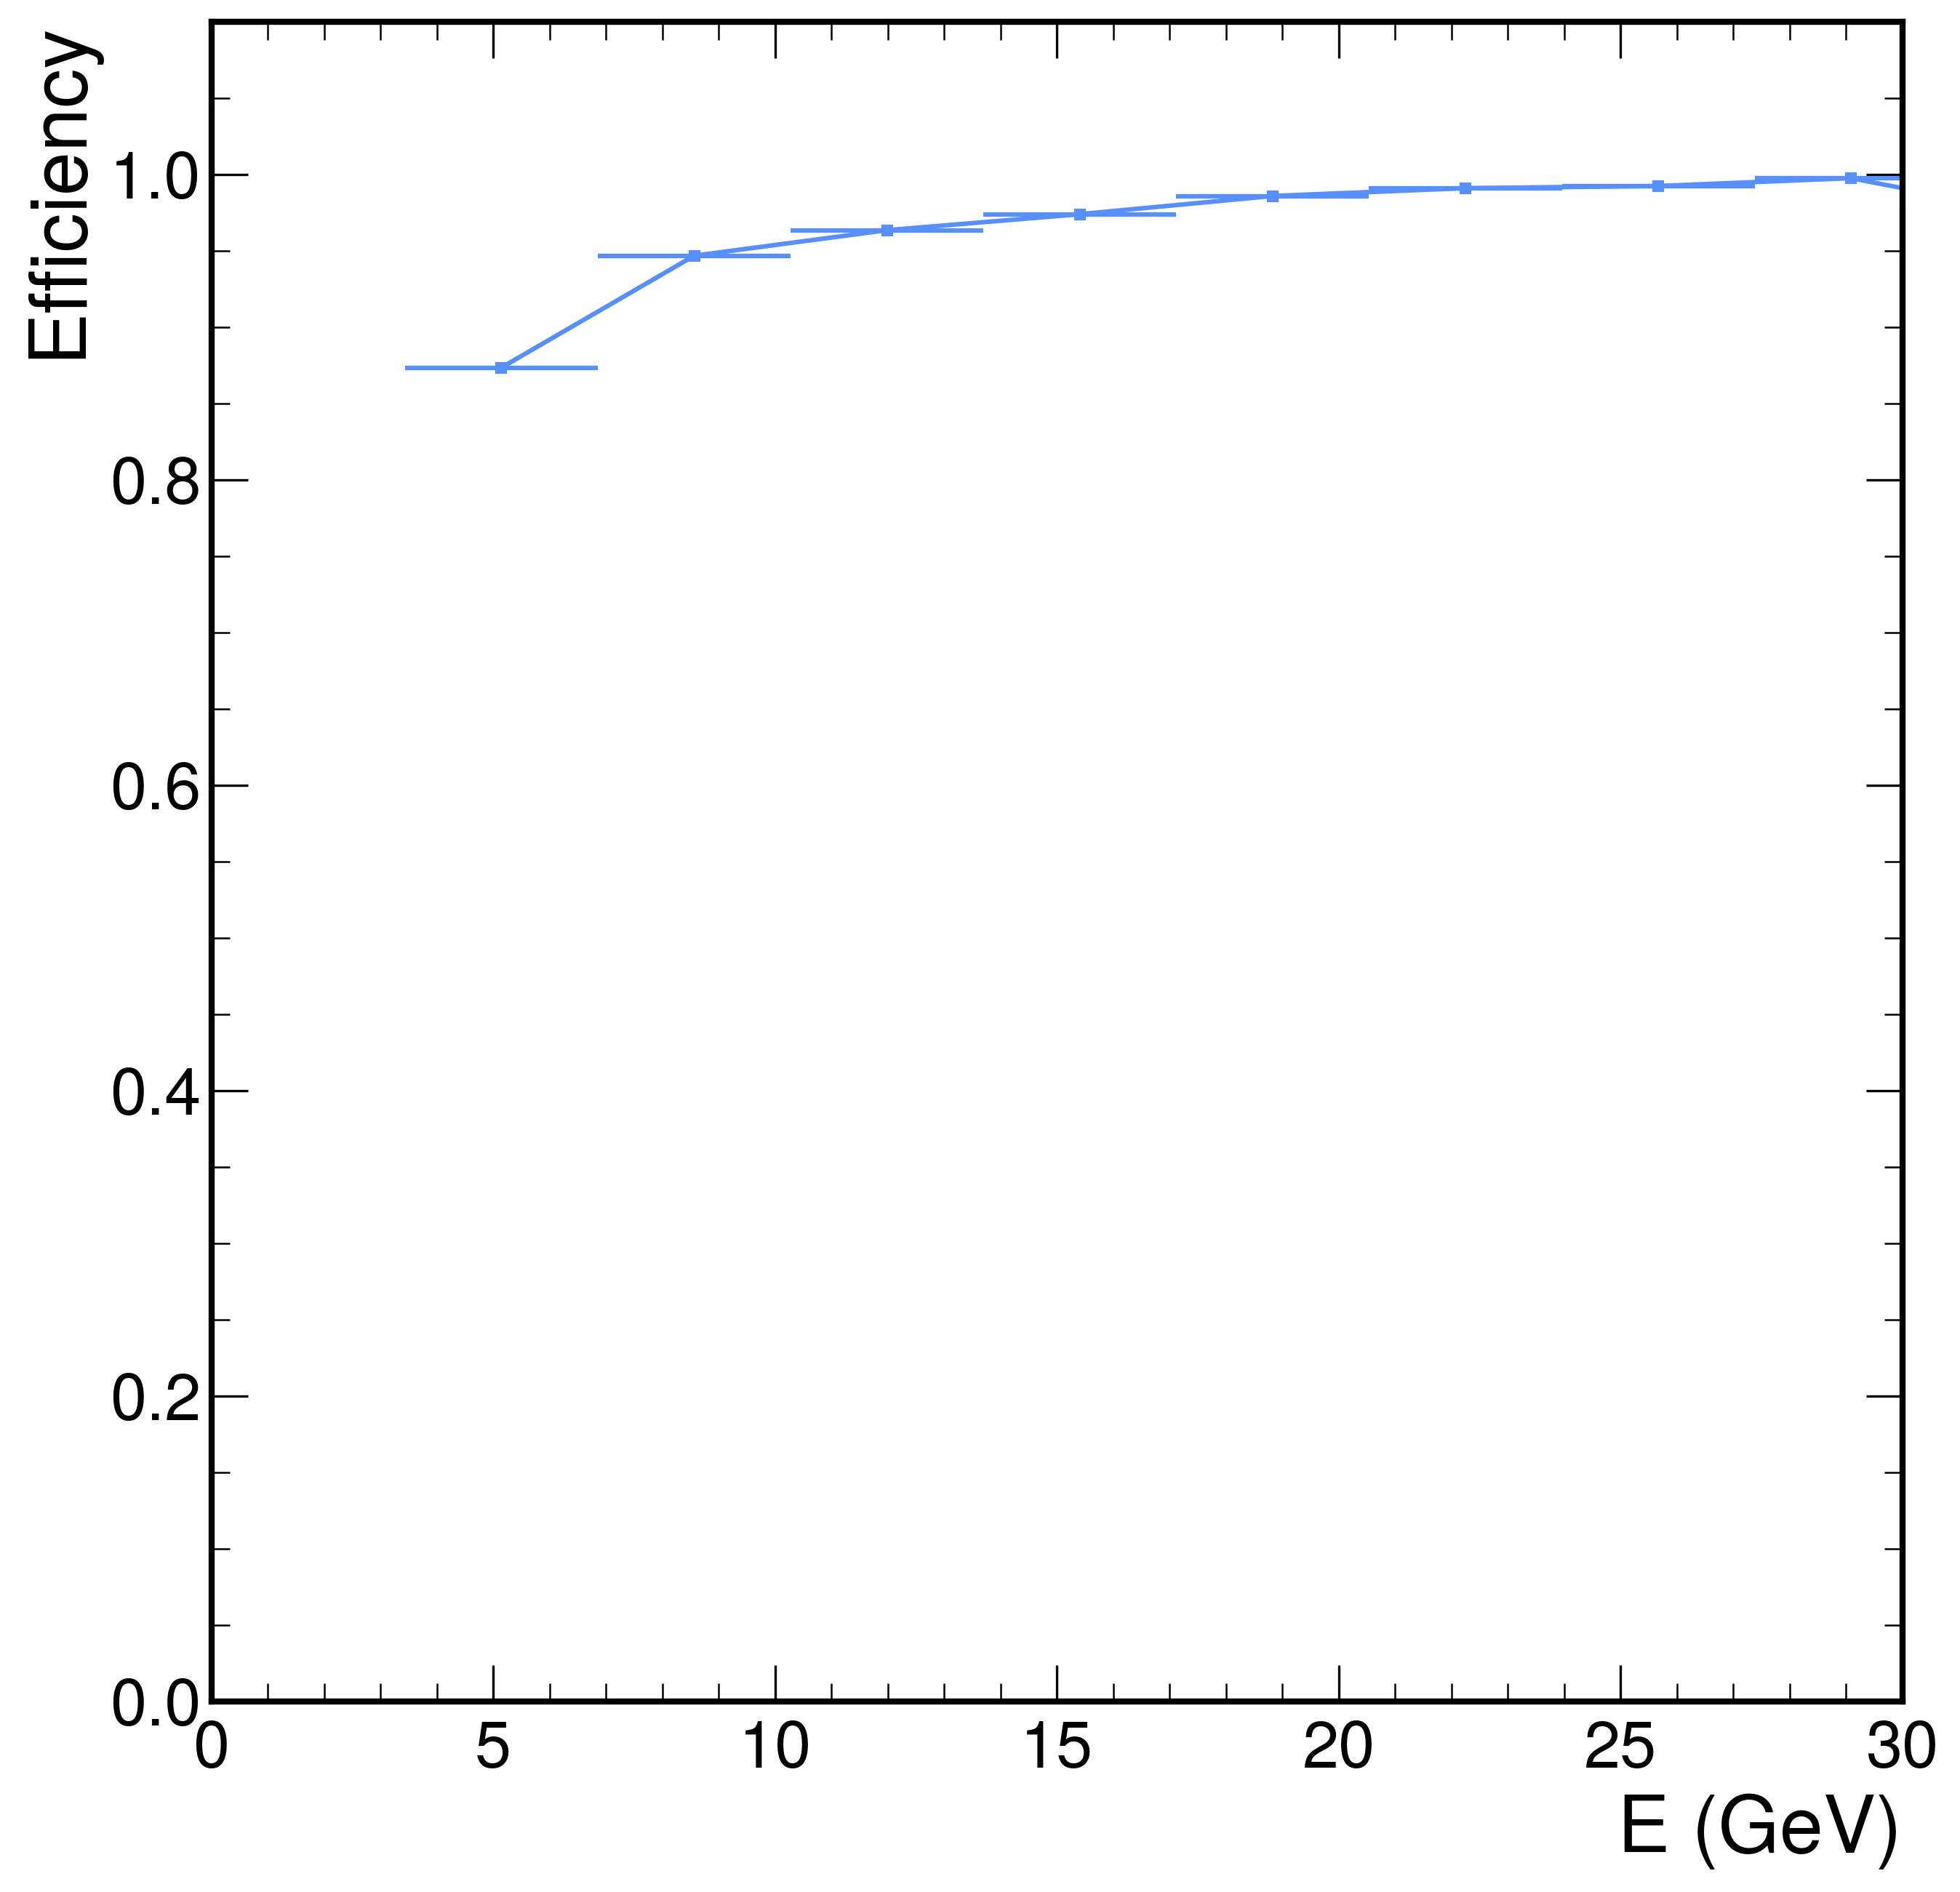

In [16]:
import matplotlib.pyplot as plt

x = (edges[1:] + edges[:-1])/2
db = (edges[1:] - edges[:-1])/2
fig, ax = plt.subplots()
ax.errorbar(x, efficiency[0], yerr=errorbars, xerr=db, marker='s', ms=3)
ax.set_ylim(0,1.1)
ax.set_xlim(0, 30)
ax.set_xlabel('E (GeV)')
ax.set_ylabel('Efficiency')


In [29]:
ver_z = tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="vertices_z")
nCP = tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="NTracksters")

In [48]:
recoToSim_score = tfile.openArray(branch_name="ticlDumper/associations", key="tsCLUE3D_recoToSim_CP_score")

<Array [0.0374, 0.0146, 0.0216, ..., 0.000334, 0.00097] type='100000 * float32'>

In [34]:
tfile.getBranchKeys(branch_name="ticlDumper/associations")

['event',
 'event/run_',
 'event/luminosityBlock_',
 'event/event_',
 'tsCLUE3D_recoToSim_SC',
 'tsCLUE3D_recoToSim_SC_score',
 'tsCLUE3D_recoToSim_SC_sharedE',
 'tsCLUE3D_simToReco_SC',
 'tsCLUE3D_simToReco_SC_score',
 'tsCLUE3D_simToReco_SC_sharedE',
 'tsCLUE3D_recoToSim_CP',
 'tsCLUE3D_recoToSim_CP_score',
 'tsCLUE3D_recoToSim_CP_sharedE',
 'tsCLUE3D_simToReco_CP',
 'tsCLUE3D_simToReco_CP_score',
 'tsCLUE3D_simToReco_CP_sharedE',
 'ticlCandidate_recoToSim_SC',
 'ticlCandidate_recoToSim_SC_score',
 'ticlCandidate_recoToSim_SC_sharedE',
 'ticlCandidate_simToReco_SC',
 'ticlCandidate_simToReco_SC_score',
 'ticlCandidate_simToReco_SC_sharedE',
 'ticlCandidate_recoToSim_CP',
 'ticlCandidate_recoToSim_CP_score',
 'ticlCandidate_recoToSim_CP_sharedE',
 'ticlCandidate_simToReco_CP',
 'ticlCandidate_simToReco_CP_score',
 'ticlCandidate_simToReco_CP_sharedE',
 'ticlCandidate_recoToSim_PU',
 'ticlCandidate_recoToSim_PU_score',
 'ticlCandidate_recoToSim_PU_sharedE',
 'ticlCandidate_simToReco_PU

In [35]:
tfile.branches

['ticlDumper;1',
 'ticlDumper/trackstersCLUE3DHigh;1',
 'ticlDumper/trackstersTiclCandidate;1',
 'ticlDumper/simtrackstersSC;1',
 'ticlDumper/simtrackstersCP;1',
 'ticlDumper/trackstersSuperclusteringDNN;1',
 'ticlDumper/clusters;1',
 'ticlDumper/candidates;1',
 'ticlDumper/superclustering;1',
 'ticlDumper/associations;1',
 'ticlDumper/tracks;1',
 'ticlDumper/simTICLCandidate;1']